In [1]:
from numpy.random.bit_generator import SeedlessSeedSequence
import tensorflow as tf
import os
import numpy as np
import random

#from tqdm import tqdm #Provides a progress bar while the images are being resized
from skimage.io import imshow, imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tifffile as tiff 
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from patchify import patchify
from sklearn.metrics import jaccard_score,  accuracy_score, f1_score, make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import cross_val_score
import random
from keras.layers import Conv3D, Reshape
from keras import backend as K
seed =42
np.random.seed=42

In [2]:
HEIGHT = 512
WIDTH = 512

In [3]:
X=[]
y=[]

for a in range(5,11):
  Xpath = '/Users/anshugusain/tf-nuclei/content/Stained-40X/Field' + str(a) + '/image.png'
  Ximg = tf.keras.preprocessing.image.load_img(Xpath)

  ypath = '/Users/anshugusain/tf-nuclei/content/Stained-40X/Field' + str(a) + '/Field' + str(a) + '-mask.tif'
  yimg = tf.keras.preprocessing.image.load_img(ypath, grayscale=True)

  Ximg = np.asarray(Ximg)
  Xpatches = patchify(Ximg,(HEIGHT,WIDTH,3), step=HEIGHT)
  yimg = np.asarray(yimg)  
  ypatches = patchify(yimg, (HEIGHT,WIDTH), step=WIDTH)

  for m in range (0,Xpatches.shape[0]):
    for l in range(0,Xpatches.shape[1]):
       y.append(ypatches[m,l])
       X.append(Xpatches[m, l,0])

X = np.array(X)
y = np.array(y)>0

X = (X/X.max())
y = (y/y.max())

/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [4]:
y.shape

(6, 512, 512)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.20, shuffle=True)

In [6]:
y_train = y_train.astype(X_train.dtype)

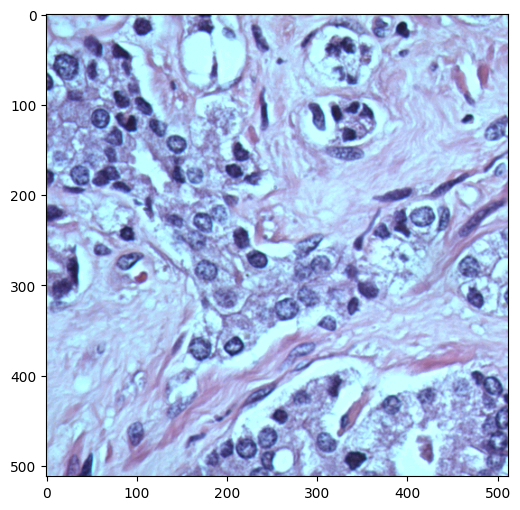

In [7]:
plt.figure(figsize=(10,6))
plt.imshow(X_train[0])


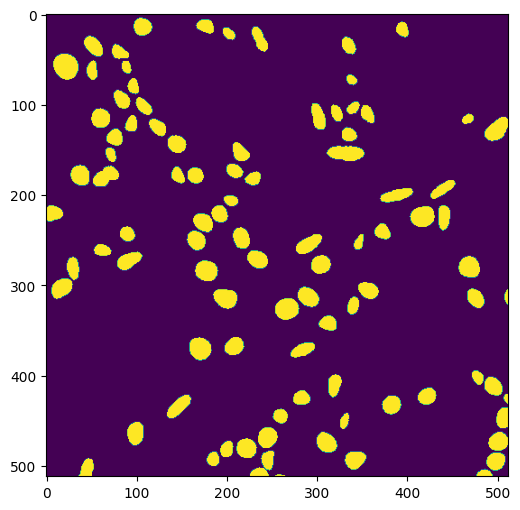

In [8]:
plt.figure(figsize=(10,6))
plt.imshow(y_train[0])

In [9]:
X_train.shape

(4, 512, 512, 3)

In [10]:
y_train.dtype

dtype('float64')

In [11]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

In [12]:
#Building the model

inputs = tf.keras.layers.Input((HEIGHT, WIDTH, 3))
s = inputs #converts integers from input layers into floating points

#Contraction Path
                           # feature space  
                           # \/
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = "relu", kernel_initializer='he_normal', padding = 'same')(s)#kernel initializer is the initial weights used by the neural network (he_normal is a trunkated normal distribution centered on 0)
c1 = tf.keras.layers.Dropout(.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = "relu", kernel_initializer="he_normal", padding = "same")(c1 ) #Padding ensures that the output image has the same dimensions as the input image
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1) #First maxpooling layer puts the values into a 2x2 matrix, and gets the maximum values

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = tf.keras.layers.Dropout(.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3= tf.keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = tf.keras.layers.Dropout(.2)(c3)
c3=tf.keras.layers.Conv2D(64,(3,3), activation = "relu", kernel_initializer="he_normal", padding="same")(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4= tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4= tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5=tf.keras.layers.Conv2D(256, (3,3), activation ="relu", kernel_initializer="he_normal", padding="same")(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)


u9= tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
u9= tf.keras.layers.concatenate([u9,c4])#Concatenates layers u6 and c4 as shown in the Unet architecture
c9=tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding="same")(u9)
c9=tf.keras.layers.Dropout(0.2)(c9)
c9=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

u10= tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c9)
u10= tf.keras.layers.concatenate([u10,c3])#Concatenates layers u6 and c4 as shown in the Unet architecture
c10=tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding="same")(u10)
c10=tf.keras.layers.Dropout(0.2)(c10)
c10=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

u11=tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c10)
u11=tf.keras.layers.concatenate([u11,c2])
c11=tf.keras.layers.Conv2D(32,(3,3), activation="relu",kernel_initializer="he_normal", padding="same")(u11)
c11=tf.keras.layers.Dropout(0.2)(c11)
c11=tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c11)

u12=tf.keras.layers.Conv2DTranspose(16, (2,2),strides=(2,2), padding="same")(c11)
u12=tf.keras.layers.concatenate([u12, c1])
c12=tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u12)
c12=tf.keras.layers.Dropout(0.1)(c12)
c12=tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c12)

outputs=tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid")(c12)
model=tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=.001), loss='binary_crossentropy', metrics='accuracy')
model.summary()

2023-11-10 10:03:46.788616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-10 10:03:46.788646: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
            

/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
X_train.shape

(4, 512, 512, 3)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [15]:
y_train.shape

(4, 512, 512)

In [16]:
filepath="/Users/anshugusain/tf-nuclei/Models/RGB-bestVAL/best_weights.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

results = model.fit(X_train, y_train, batch_size = 1, epochs=100, shuffle=False, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/100


2023-11-10 10:03:48.918599: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-10 10:03:49.502534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x512x512x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must

1/4 [======>.......................] - ETA: 5s - loss: 0.7431 - accuracy: 0.3177

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x128x64xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x256x256x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerfo

4/4 [==============================] - ETA: 0s - loss: 0.6220 - accuracy: 0.6569

2023-11-10 10:03:50.983999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.84442, saving model to /Users/anshugusain/tf-nuclei/Models/RGB-bestVAL/best_weights.h5
4/4 [==============================] - 2s 239ms/step - loss: 0.6220 - accuracy: 0.6569 - val_loss: 0.4387 - val_accuracy: 0.8444
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.8842
Epoch 2: val_accuracy improved from 0.84442 to 0.86308, saving model to /Users/anshugusain/tf-nuclei/Models/RGB-bestVAL/best_weights.h5
4/4 [==============================] - 0s 108ms/step - loss: 0.4478 - accuracy: 0.8842 - val_loss: 0.3885 - val_accuracy: 0.8631
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8915
Epoch 3: val_accuracy did not improve from 0.86308
4/4 [==============================] - 0s 77ms/step - loss: 0.3216 - accuracy: 0.8915 - val_loss: 0.3441 - val_accuracy: 0.8631
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8915
Epoch 4: val_a

In [17]:
model = tf.keras.models.load_model('/Users/anshugusain/tf-nuclei/Models/RGB-bestVAL/best_weights.h5')
#model = tf.keras.models.load_model('/Users/anshugusain/tf-nuclei/Models/RGB-bestVAL/RGB_best-5.h5')
#model = tf.keras.models.load_model('/Users/anshugusain/tf-nuclei/Models/RGB-bestVAL/RGB_best-36.h5', custom_objects={'jacard_coef_loss': jacard_coef_loss,'jacard_coef':jacard_coef})
#model = tf.keras.models.load_model('/Users/anshugusain/tf-nuclei/Models/RGB-bestVAL/best_weights.h5', custom_objects={'jacard_coef_loss': jacard_coef_loss,'jacard_coef':jacard_coef})

In [18]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [30]:
def show_predictions(dataset=None, num=1):
    test_predict = model.predict(np.expand_dims(X_test[num],0))
    test_predict = np.asarray(test_predict)
    display([X_test[num], y_test[num], (test_predict.squeeze())>0.1])
    

In [31]:
X_test.shape

(2, 512, 512, 3)

1/1 [==============================] - 0s 17ms/step


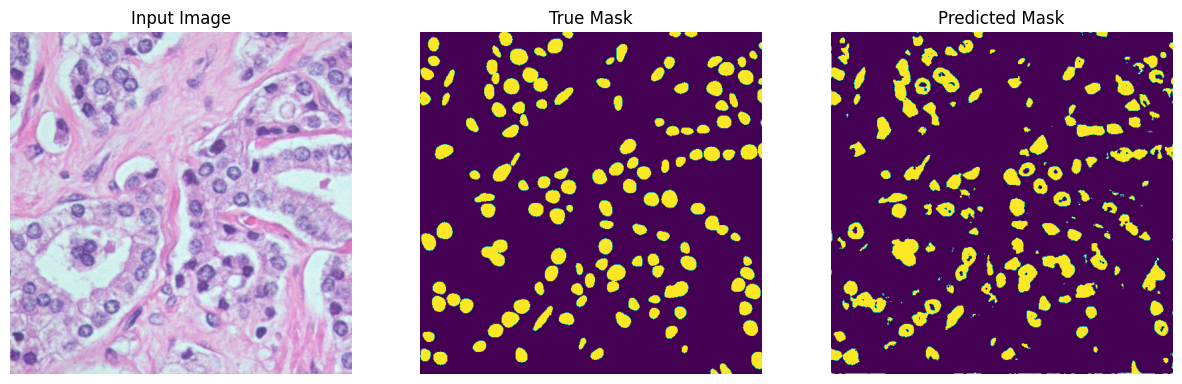

In [32]:
show_predictions(X_test ,0)

In [27]:
def average_calc(X_examine, y_examine):
  IoUs = [len(X_examine)]
  total =0
  average =0

  for i in range(0,len(X_examine)):
    test_predict = model.predict(np.expand_dims(X_examine[i],0))
    test_predict = np.asarray(test_predict) 
    IoU = jaccard_score((test_predict>0.5).squeeze(), (y_examine[i]>0.5).squeeze(), average='micro')
    total =IoU + total
  average = total / len(X_examine)
  
  return average

def average_Fscore(X_examine, y_examine):
  IoUs = [len(X_examine)]
  total =0
  average =0

  for i in range(0,len(X_examine)):
    test_predict = model.predict(np.expand_dims(X_examine[i],0))
    test_predict = np.asarray(test_predict) 
    IoU = f1_score((test_predict>0.5).squeeze(), (y_examine[i]).squeeze(), average='micro')
    total =IoU + total
  average = total / len(X_examine)
  
  return average

In [28]:
average_calc(X_test, y_test)

1/1 [==============================] - 0s 16ms/step


0.4632215952784706

In [29]:
average_Fscore(X_test, y_test)

1/1 [==============================] - 0s 16ms/step


0.6250969661940817

1/1 [==============================] - 0s 22ms/step


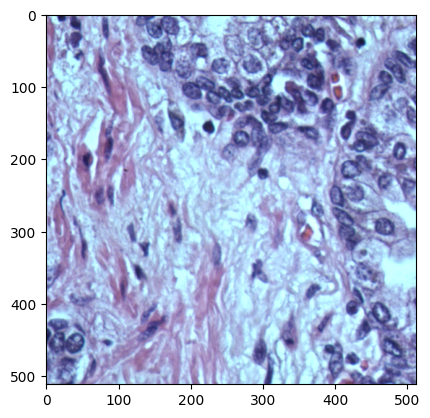

<Figure size 1000x600 with 0 Axes>

In [25]:
test_predict = model.predict(np.expand_dims(X_test[image_num],0))
plt.imshow(X_test[image_num])
plt.figure(figsize=(10,6))
test_predict = np.asarray(test_predict)

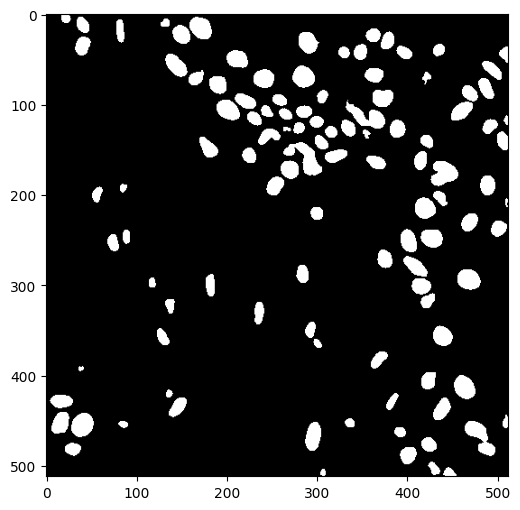

In [26]:
plt.figure(figsize=(10,6))
plt.imshow(test_predict.squeeze()>.9,cmap='gray')

In [ ]:
from PIL import Image
im = Image.fromarray(test_predict)
im.save("output.jpeg")

In [ ]:
print("hello")

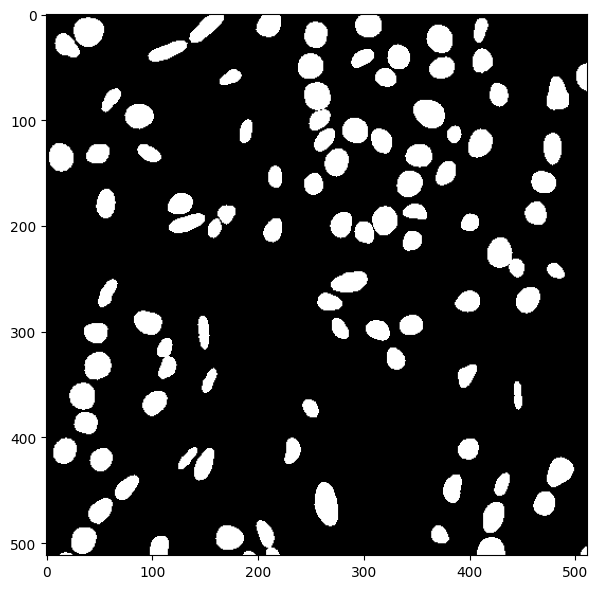

In [189]:
plt.figure(figsize=(10,6))
plt.imshow((y_test[0]>0).squeeze(),cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


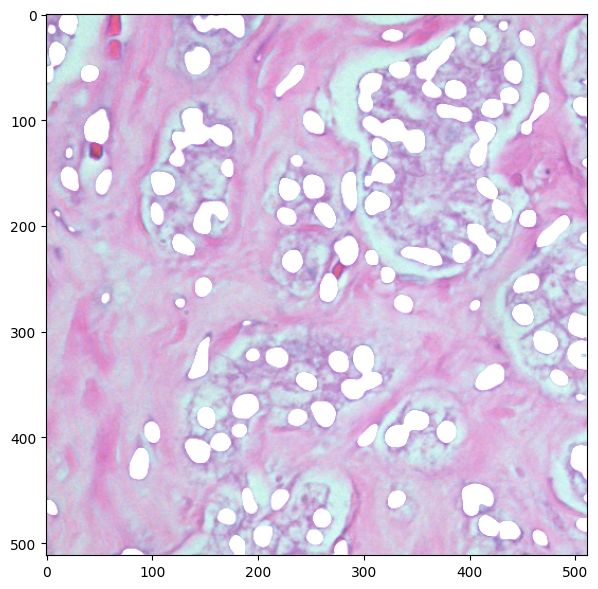

In [220]:
overlayed = np.add(test_predict, X_test[image_num])
plt.figure(figsize=(10,6))
plt.imshow(overlayed.squeeze())

<Figure size 700x350 with 0 Axes>

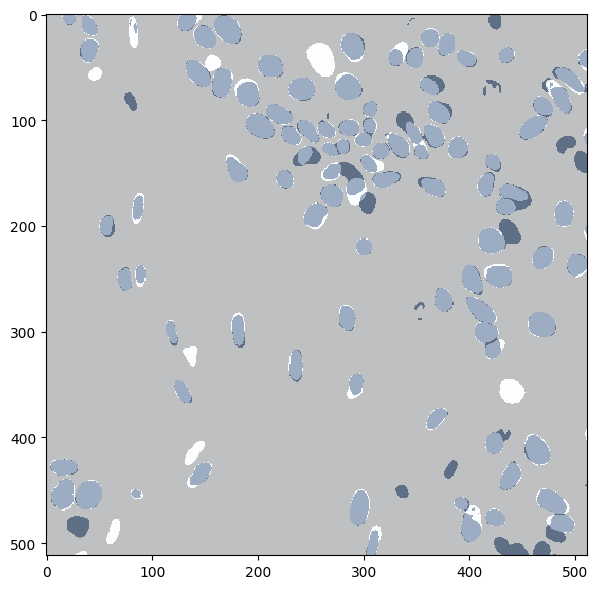

In [115]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
mask = test_predict.squeeze()>.5
im = y_test[image_num]
masked = np.ma.masked_where(mask == 0, mask)
plt.figure()
#plt.subplot(1, 2, 1)
#plt.imshow(im, 'gray', interpolation='none')
#plt.subplot(1, 2, 2)
plt.figure(figsize=(10,6))
plt.imshow(im, 'gray', interpolation='none', alpha = .4)
plt.imshow(mask,"Blues", interpolation='none', alpha=.4)
plt.show()

##Statistical Analysis

In [53]:
IoU = jaccard_score((test_predict>.5).squeeze(), y_test[image_num].squeeze(), average='micro')
IoU

0.753882493483927

In [45]:
f1score = f1_score(y_test[image_num].squeeze(), (test_predict>.4).squeeze(), average='micro')
f1score

0.8910067427537289

In [46]:
accuracy = accuracy_score((test_predict>.3).squeeze(), y_test[image_num].squeeze(), normalize=True)
accuracy

0.001953125

FULL SLIDE PREDICTION

In [47]:
def prediction(model, image, patch_size):
    segm_img = np.zeros(image.shape[:2])  #Array with zeros to be filled with segmented values
    patch_num=1
    for i in range(0, image.shape[0], 256):   #Steps of 256
        for j in range(0, image.shape[1], 256):  #Steps of 256
            #print(i, j)
            single_patch = image[i:i+patch_size, j:j+patch_size]
            single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
            single_patch_shape = single_patch_norm.shape[:2]
            single_patch_input = np.expand_dims(single_patch_norm, 0)
            single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
            segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
          
            print("Finished processing patch number ", patch_num, " at position ", i,j)
            patch_num+=1
    return segm_img

In [1]:
import numpy as np
import time

# Size of the square matrices
N = 16000

# Generate random matrices
A = np.random.rand(N, N)
B = np.random.rand(N, N)

# Record start time
start_time = time.time()

# Perform matrix multiplication
C = np.dot(A, B)

# Record end time
elapsed_time = time.time() - start_time
print(f"Matrix multiplication of size {N}x{N} took {elapsed_time:.2f} seconds")

Matrix multiplication of size 16000x16000 took 22.55 seconds
